# Project 1 What Makes You Happy?
### _Author: Fei Zheng_

## 0. Preparation

A general descriptions for the libraries from official documents:  
+ `sys`: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
+ `warnings`: Warning messages are typically issued in situations where it is useful to alert the user of some condition in a program, where that condition (normally) doesn’t warrant raising an exception and terminating the program.
+ `re`: This module provides regular expression matching operations similar to those found in Perl.
+ `random`: This module implements pseudo-random number generators for various distributions.
+ `pandas`: Pandas provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
+ `numpy`: NumPy is the fundamental package for scientific computing in Python.
+ `matplotlib`: Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
+ `nltk`: NLTK is a leading platform for building Python programs to work with human language data.  
  
There are some other libraries and functions I will use later. Following the general rule, I will import them when necessary, where the description will be attached also.

In [2]:
# load libraries and functions
from __future__ import print_function
import sys
import warnings
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import plotly.offline as py
import plotly.graph_objs as go

In [3]:
# ignore some warnings
py.init_notebook_mode(connected=True)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [4]:
# print the python version
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## 1. Load the data and have a general view

In [93]:
# read the data from subfolder `data` in the project
hm_data = pd.read_csv('../data/HappyDB/happydb/data/cleaned_hm.csv')

First, let's geta general sense of the data!  
For convenience, here is a variables' descriotion copied from official github documents.  
+ __hmid (int)__: Happy moment ID
+ __wid (int)__: Worker ID
+ __reflection_period (str)__: Reflection period used in the instructions provided to the worker (3m or 24h)
+ __original_hm (str)__: Original happy moment
+ __cleaned_hm (str)__: Cleaned happy moment
+ __modified (bool)__: If True, original_hm is "cleaned up" to generate cleaned_hm (True or False)
+ __predicted_category (str)__: Happiness category label predicted by our classifier (7 categories. Please see the reference for details)
+ __ground_truth_category (str)__: Ground truth category label. The value is NaN if the ground truth label is missing for the happy moment
+ __num_sentence (int)__: Number of sentences in the happy moment

In [94]:
hm_data.head(10)

hmid   wid reflection_period  \
0  27673  2053               24h   
1  27674     2               24h   
2  27675  1936               24h   
3  27676   206               24h   
4  27677  6227               24h   
5  27678    45               24h   
6  27679   195               24h   
7  27680   740               24h   
8  27681     3               24h   
9  27682  4833               24h   

                                         original_hm  \
0  I went on a successful date with someone I fel...   
1  I was happy when my son got 90% marks in his e...   
2       I went to the gym this morning and did yoga.   
3  We had a serious talk with some friends of our...   
4  I went with grandchildren to butterfly display...   
5                            I meditated last night.   
6  I made a new recipe for peasant bread, and it ...   
7  I got gift from my elder brother which was rea...   
8            YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED   
9  Watching cupcake wars with my three teen children   

                                          cleaned_hm  modified  num_sentence  \
0  I went on a successful date with someone I fel...      True             1   
1  I was happy when my son got 90% marks in his e...      True             1   
2       I went to the gym this morning and did yoga.      True             1   
3  We had a serious talk with some friends of our...      True             2   
4  I went with grandchildren to butterfly display...      True             1   
5                            I meditated last night.      True             1   
6  I made a new recipe for peasant bread, and it ...      True             1   
7  I got gift from my elder brother which was rea...      True             1   
8            YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED      True             1   
9  Watching cupcake wars with my three teen children      True             1   

  ground_truth_category predicted_category  
0                   NaN          affection  
1                   NaN          affection  
2                   NaN           exercise  
3               bonding            bonding  
4                   NaN          affection  
5               leisure            leisure  
6                   NaN        achievement  
7                   NaN          affection  
8                   NaN   enjoy_the_moment  
9                   NaN          affection

Obviously, `cleaned_hm` must be my main focus.  
There are so many missing values in `ground_truth_category` that makes it difficult to deal with.  
Luckily, we have `predicted_category` which has 7 categories. This might provide some useful information!  
And also, official database provides some affiliated `.csv` documents(e.g., `senselabel.csv`, `pets-dict.csv`) which might be useful later.   

## 2. Text Preprocessing

Whatever, let's first process `cleaned_hm`.  
Generally, there are several standard steps for text preprocessing. I summarize below:    
1. Transform sentences into words, which is also called `tokenization`.  
2. Tag the part of speech, which is called `POS Tagging`(Optional).   
3. Remove the punctuation and non-alpha words(e.g. numbers, whitespace).  
4. Correct the spelling mistakes.  
5. Transform all words into lowercase. 
6. `Lemmatization/Stemming`.  
7. Remove too short words and stopwords.

#### Step1. Tokenization

In [95]:
hm = hm_data['cleaned_hm'].copy()
token_hm = [nltk.word_tokenize(sent) for sent in hm]

#### Step2. POS tagging

In [96]:
pos_hm = (nltk.pos_tag(sent) for sent in token_hm)

#### Step3. Remove the punctuation and non-alpha words

`string.punctuation`: This is a string of ASCII characters which are considered punctuation characters in the C locale.  
!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~

In [97]:
from string import punctuation
punct_hm = [[tup for tup in sent if re.search(r'\D+', tup[0]) and tup[0] not in list(punctuation) 
            and tup[0] not in ["'s","'d","'ll",'',"'m","'ve"]]
             for sent in pos_hm]

#### Step4. Check the spelling mistakes

`pyenchant`: This package provides a set of Python language bindings for the Enchant spellchecking library.[@rfk/pyenchant](https://github.com/rfk/pyenchant)

In [79]:
import enchant
d = enchant.Dict('en_US') # US English
check_hm = [[d.check(tup[0]) for tup in sent] for sent in punct_hm]
num_mis = len([word for sent in check_hm for word in sent if word == False])
print('There are {0} spelling mistakes. The mistake rate is {1:.2f}%'.format(num_mis,
    100 * num_mis/len([word for sent in check_hm for word in sent])))

There are 34889 spelling mistakes. The mistake rate is 1.90%


Let's have a look at what kind of the spelling mistakes they are.

In [80]:
# get all the indexes for the spelling mistake(False)
indexes = [[i,j] for i in range(len(check_hm)) for j,x in enumerate(check_hm[i]) if x == False]

# randomly choose 10 some spelling mistakes
random.seed(1)
for i in range(10):
    choice = random.choice(range(len(indexes)))
    idx1 = indexes[choice][0]
    idx2 = indexes[choice][1]
    print('The mistake word is: {0}.\nThe sentence is: {1} \n'.format(punct_hm[idx1][idx2][0], hm[idx1]))

The mistake word is: glitched.
The sentence is: I got a free pack of cigarettes because the computer glitched out when I went to pay. 

The mistake word is: n't.
The sentence is: My knee didn't hurt all day. 

The mistake word is: Overwatch.
The sentence is: I managed to properly figure out how a recent update to Overwatch would impact the DPS of various characters, and how that might affect balance. 

The mistake word is: cryptocurrency.
The sentence is: The coin on a cryptocurrency exchange that I was hoping would drop in price so I could buy it, droppedd a lot in price and I was able to buy a lot of it for cheap. 

The mistake word is: harvard.
The sentence is: My kids will be able to see thier farther go to harvard 

The mistake word is: Veenhoven.
The sentence is: happiness in terms of living a good life, or flourishing, rather than simply as an emotion. Happiness in this sense was used to translate the Greek eudaimonia, and is still used in virtue ethics. There has been a transit

From the random examples above, some mistakes come from abbreviation(e.g. **don't** will be tokenized into **do** and **n't**) which is very meaningful and can be partly dealt with by **POS tagging** in **nltk**. Some other mistakes come from special words(e.g **harvard**, **facebook**).  
  
It's tough to deal with such spelling problems. Considering the low misspelling rate, we could just ignore them.  

#### Step5. Transform to lowercase

In [98]:
lower_hm = [[(tup[0].lower(), tup[1]) for tup in sent] for sent in punct_hm]

#### Step6. Lemmatization

In [99]:
# def the function that convert the POS from original form to consistent form
from nltk.corpus import wordnet
def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [100]:
wnl = nltk.WordNetLemmatizer()
lemma_hm = [[(wnl.lemmatize(tup[0], get_pos(tup[1])), tup[1]) for tup in sent] for sent in lower_hm]

#### Step6. Remove too short words and stopwords

In [101]:
# remove words whose length < 3 and remove stopwords
from nltk.corpus import stopwords
words = stopwords.words('english') + ["happy","ago","yesterday","lot","today","month","last","week","past",
                                     "get","make","day","n't","take","year","time"]
stop_hm = [[tup for tup in sent 
            if len(tup[0]) >= 3 and tup[0] not in words and not re.search(r"^\'[a-zA-Z]", tup[0])] 
           for sent in lemma_hm]

#### Step7. Combine the processed text to the original data and export

In [102]:
hm_data['preprocess_hm'] = [' '.join([tup[0] for tup in sent]) for sent in stop_hm]
hm_data['preprocess_ori_hm'] = [' '.join([tup[0] for tup in sent]) for sent in lower_hm]
hm_data.to_csv('../output/preprocess_hm.csv', index=False)

## 3. Exploratory Data Analysis

In [106]:
# combine the processed data with demographic data
hm_data = pd.read_csv('../output/preprocess_hm.csv')
demo_data = pd.read_csv('../data/HappyDB/happydb/data/demographic.csv')
hm_data = hm_data.merge(demo_data, on = 'wid', how = 'inner', copy=False)

In [107]:
# select rows that satisfies specific row conditions and export
# transform Age to integer and count the words
def trans_age(age):
    try:
        return int(float(age))
    except:
        return np.nan
def word_count(words):
    try:
        return len(words.strip().split(' '))
    except:
        return np.nan

hm_data = hm_data.assign(age = hm_data['age'].map(trans_age),
                        word_count = hm_data['preprocess_hm'].map(word_count))

# filter the rows
hm_data_sub = hm_data.loc[(hm_data['gender'].isin(['m','f'])) &
                     (hm_data['marital'].isin(['single','married','divorced'])) &
                     (hm_data['parenthood'].isin(['n','y'])) &
                     (hm_data['reflection_period'].isin(['3m','24h']))&
                     (hm_data['age'].between(1,100)) &
                     (~hm_data['preprocess_hm'].isnull()) &
                     (hm_data['word_count'] > 1)
                         ,['wid','original_hm','cleaned_hm','predicted_category',
                          'preprocess_hm','age','country','gender','marital','parenthood','word_count','preprocess_ori_hm']]
# export
hm_data_sub.to_csv('../output/clean_hm.csv', index = False)

### 3.1 What's the difference in sentence length?

In [90]:
hm_data = pd.read_csv('../output/clean_hm.csv')
def length_count(sent):
    return len(sent.strip().split(' '))
hm_data['length'] = hm_data['preprocess_ori_hm'].map(length_count)

In [161]:
# there word length is a long-tail distribution
trace0 = go.Histogram(x = hm_data['length'])
data = [trace0]
layout = go.Layout(
    title = 'Sentence Length',
    margin=dict(
        l=50,
        r=50,
        b=80,
        t=100,
    ),
    xaxis={
        'title': 'Length',
        'zeroline': False,
        'range': [0,120]
    },
    yaxis={
        'title': 'Count'
    }
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='../figs/1.png')

The word length is long-tail distribution, which is not good for visualization among different demographic characteristics.

In [193]:
trace0 = go.Bar(
    y = hm_data.loc[hm_data['length'] > 100,'gender'].value_counts().values,
    x = hm_data.loc[hm_data['length'] > 100,'gender'].value_counts().index,
    showlegend=False
)
trace1 = go.Bar(
    y = hm_data.loc[hm_data['length'] > 100,'marital'].value_counts().values,
    x = hm_data.loc[hm_data['length'] > 100,'marital'].value_counts().index,
    showlegend=False
)
trace2 = go.Bar(
    y = hm_data.loc[hm_data['length'] > 100,'parenthood'].value_counts().values,
    x = hm_data.loc[hm_data['length'] > 100,'parenthood'].value_counts().index,
    showlegend=False
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = 'Those says a lot',
    margin=dict(
        l=50,
        r=50,
        b=80,
        t=100,
    ),
    xaxis={
        'title': 'Length',
        'zeroline': False
    },
    yaxis={
        'title': 'Count'
    }
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='../figs/2.png')
#hm_data.loc[hm_data['length'] > 100, 'gender']
#hm_data.loc[hm_data['length'] > 100, 'age'].value_counts()

### 3.2 What's about the words frequency?

In [204]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS, max_words=50, background_color="white")
def wordcloud_gen(characteristic, name):
    return wordcloud.generate_from_frequencies(dict(pd.Series(
    [words for sent in hm_data.loc[hm_data[str(characteristic)] == str(name), 'preprocess_hm'] 
     for words in sent.strip().split(' ')]).value_counts()))

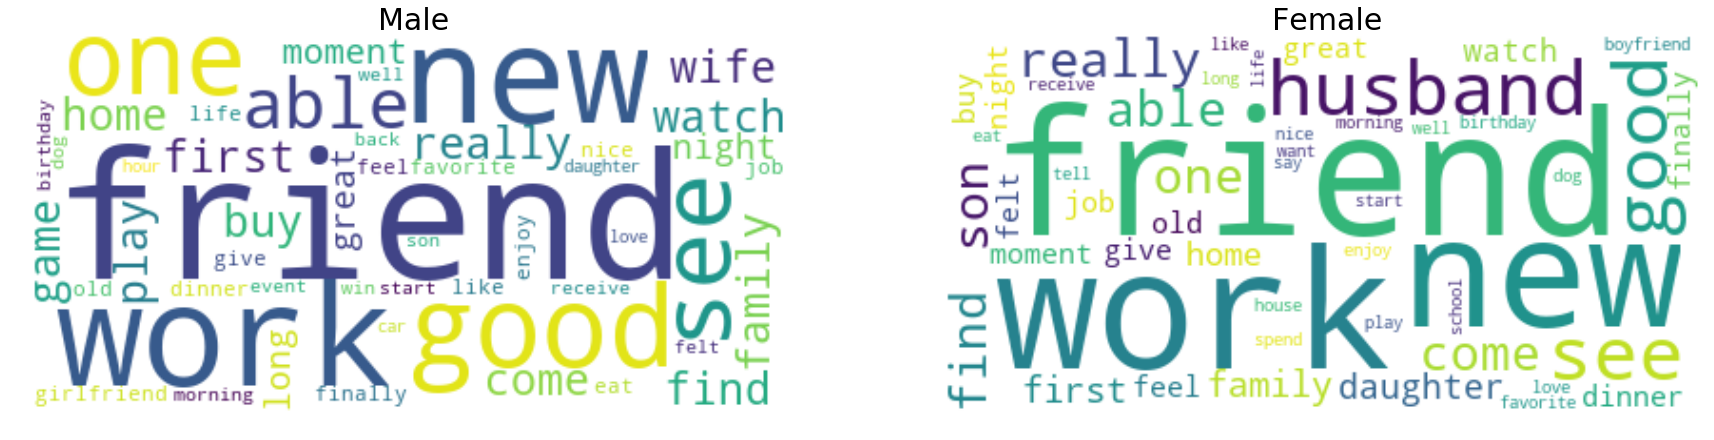

In [220]:
fig,axes = plt.subplots(1,2,figsize=(30,20))

ax = axes[0]
ax.imshow(wordcloud_gen('gender','m'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Male", fontsize=30)

ax = axes[1]
ax.imshow(wordcloud_gen('gender','f'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Female", fontsize=30)

plt.show()

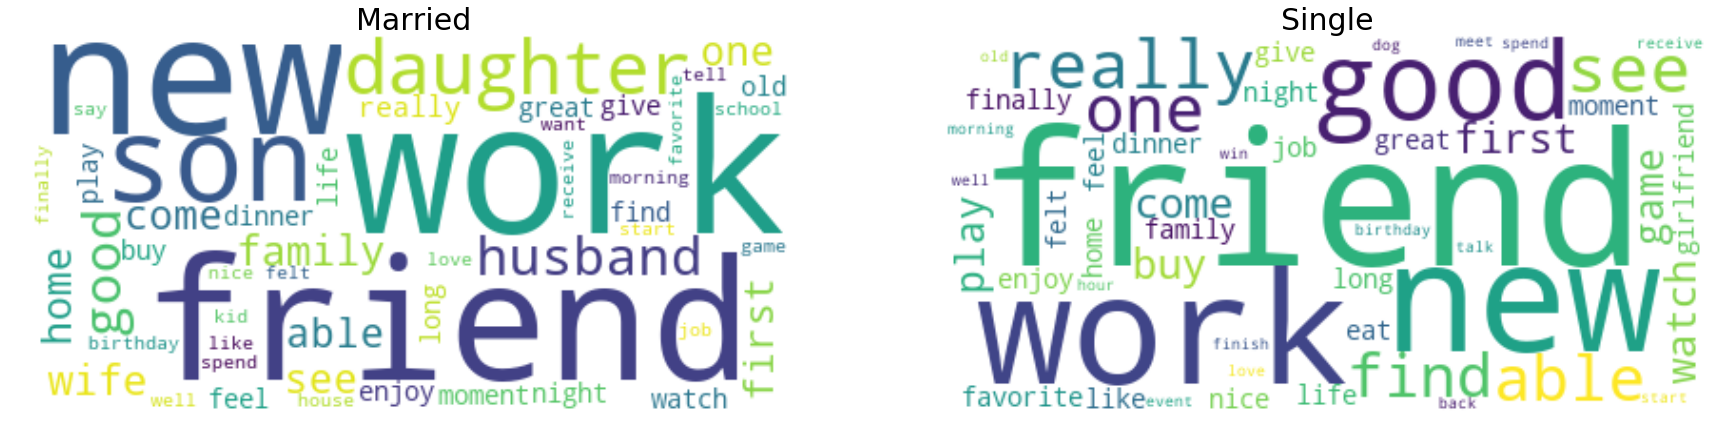

In [221]:
fig,axes = plt.subplots(1,2,figsize=(30,20))

ax = axes[0]
ax.imshow(wordcloud_gen('marital','married'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Married", fontsize=30)

ax = axes[1]
ax.imshow(wordcloud_gen('marital','single'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Single", fontsize=30)

plt.show()

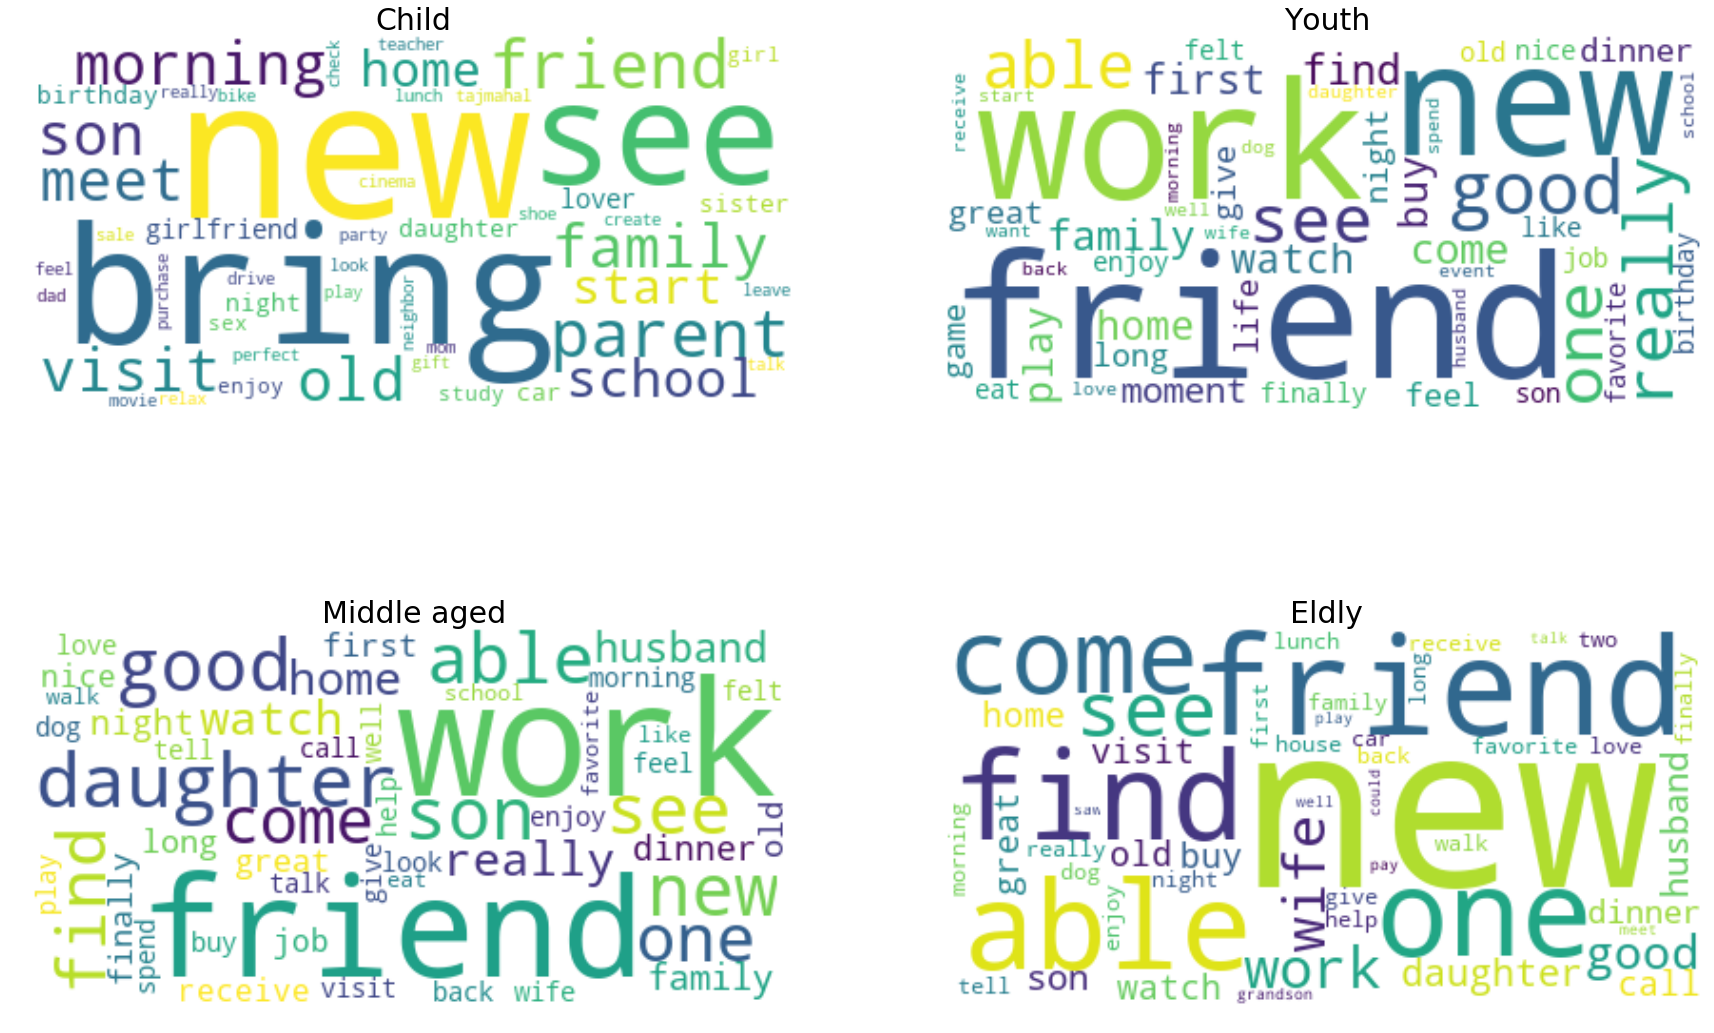

In [224]:
hm_data['Age'] = pd.cut(hm_data['age'], bins=[-1,15,44,59,100], labels=['Child','Youth','Middle aged','Eldly'])

fig,axes = plt.subplots(2,2,figsize=(30,20))

ax = axes[0,0]
ax.imshow(wordcloud_gen('Age','Child'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Child", fontsize=30)

ax = axes[0,1]
ax.imshow(wordcloud_gen('Age','Youth'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Youth", fontsize=30)

ax = axes[1,0]
ax.imshow(wordcloud_gen('Age','Middle aged'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Middle aged", fontsize=30)

ax = axes[1,1]
ax.imshow(wordcloud_gen('Age','Eldly'), interpolation="bilinear")
ax.axis('off')
ax.set_title("Eldly", fontsize=30)

plt.show()

## 4.  Model: Latent Dirichlet Analysis (LDA)

In [5]:
# input the data
hm_data = pd.read_csv('../output/clean_hm.csv')
hm = hm_data['preprocess_hm']
hm = [x for x in hm]

### LDA

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics.[WIKI-LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

In [6]:
# word count
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(strip_accents = 'unicode',
                     stop_words = 'english',
                     lowercase = True,
                     token_pattern = r'\b[a-zA-Z]{3,}\b',
                     max_df = 0.5, 
                     min_df = 10)
hm_tf = tf.fit_transform(hm)

In [9]:
# lda modeling
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=16,
                                learning_method='online',
                                random_state=42)
lda.fit(hm_tf)
doc_topic0 = lda.fit_transform(hm_tf)

### Visualizatin by t-distributed Stochastic Neighbor Embedding (t-SNE)

T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. [WIKI-tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [17]:
from sklearn.manifold import TSNE
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

threshold = 0.5
idx = np.max(doc_topic0, axis=1) > threshold  # idx of doc that above the threshold
doc_topic1 = doc_topic0[idx]

tsne = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
hm_tsne = tsne.fit_transform(doc_topic1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16639 samples in 0.012s...
[t-SNE] Computed neighbors for 16639 samples in 4.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16639
[t-SNE] Computed conditional probabilities for sample 2000 / 16639
[t-SNE] Computed conditional probabilities for sample 3000 / 16639
[t-SNE] Computed conditional probabilities for sample 4000 / 16639
[t-SNE] Computed conditional probabilities for sample 5000 / 16639
[t-SNE] Computed conditional probabilities for sample 6000 / 16639
[t-SNE] Computed conditional probabilities for sample 7000 / 16639
[t-SNE] Computed conditional probabilities for sample 8000 / 16639
[t-SNE] Computed conditional probabilities for sample 9000 / 16639
[t-SNE] Computed conditional probabilities for sample 10000 / 16639
[t-SNE] Computed conditional probabilities for sample 11000 / 16639
[t-SNE] Computed conditional probabilities for sample 12000 / 16639
[t-SNE] Computed conditional probabilities for sam

In [32]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

lda_keys0 = []
for i in range(doc_topic0.shape[0]):
    lda_keys0.append(doc_topic0[i].argmax())

lda_keys1 = [x for i,x in enumerate(lda_keys0) if idx[i] == True]

topic_summaries = []
topic_word = lda.components_
vocab = tf.get_feature_names()
n_top_words=5

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    topic_summaries.append(' '.join(topic_words))

In [138]:
title='HM_16'
num_example = len(doc_topic1)
hm_plot = bp.figure(plot_width=1000, plot_height=800,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

source = bp.ColumnDataSource(dict(x = hm_tsne[:,0], y = hm_tsne[:,1], color = colormap[lda_keys1][:num_example],
                  content = hm[:num_example], topic_key = lda_keys1[:num_example]))
hm_plot.scatter(x='x', y='y', color='color', source = source)

GlyphRenderer(id='2820', ...)

In [139]:
topic_coord = np.empty((doc_topic1.shape[1], 2)) * np.nan
for topic_num in lda_keys1:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = hm_tsne[lda_keys1.index(topic_num)]

# plot crucial words
for i in range(doc_topic1.shape[1]):
    hm_plot.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = hm_plot.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(hm_plot, '../figs/{}.html'.format(title))

'/Users/james/Desktop/Lectures/GR5243_Applied_Data_Science/Spring2019-Proj1-zhengfei0908/figs/HM_16.html'

In [140]:
from IPython.core.display import HTML, display
HTML('../figs/HM_16.html')

### Another visualization by `pyLDAvis`

In [148]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.prepare(topic_term_dists=topic_word, doc_topic_dists = doc_topic0,
                 doc_lengths=hm_data['preprocess_ori_hm'].map(length_count).values, 
                 vocab=vocab, term_frequency=np.array(hm_tf.sum(axis=0)).flatten(), mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
3     -290.707062  137.767426       1        1  9.243815
14    -250.294296 -407.355042       2        1  8.209082
2      222.461029 -265.101807       3        1  7.110094
6     -217.088242  408.642395       4        1  6.799750
5     -514.348022 -283.236053       5        1  6.567408
9      119.688698  -14.748631       6        1  6.249748
12    -538.057922   12.959362       7        1  6.173939
13      70.426300  447.436920       8        1  6.073415
7     -305.858093 -134.992279       9        1  5.827673
1     -484.047699  303.907104      10        1  5.701349
11     247.652359  225.371521      11        1  5.659222
8     -112.033005   -8.800961      12        1  5.635154
10     377.956940  -27.591022      13        1  5.584347
0      -29.584850  208.914230      14        1  5.157950
15     -47.401321 -230.090820      15        1  5.031241
4       30.815056 -476.737305      16        1  4.975812, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
1625  Default  1.337339e+09      friend  1.337339e+09  30.0000  30.0000
4387  Default  1.410878e+09        work  1.410878e+09  29.0000  29.0000
2628  Default  9.420728e+08         new  9.420728e+08  28.0000  28.0000
780   Default  7.848484e+08        come  7.848484e+08  27.0000  27.0000
1723  Default  6.271823e+08        good  6.271823e+08  26.0000  26.0000
3173  Default  6.467571e+08      really  6.467571e+08  25.0000  25.0000
1464  Default  5.831733e+08      family  5.831733e+08  24.0000  24.0000
4300  Default  4.922035e+08       watch  4.922035e+08  23.0000  23.0000
2315  Default  5.045728e+08        long  5.045728e+08  22.0000  22.0000
1533  Default  5.004122e+08     finally  5.004122e+08  21.0000  21.0000
535   Default  4.643211e+08         buy  4.643211e+08  20.0000  20.0000
1501  Default  5.237000e+08        feel  5.237000e+08  19.0000  19.0000
2269  Default  5.158046e+08        life  5.158046e+08  18.0000  18.0000
1900  Default  3.868133e+08        home  3.868133e+08  17.0000  17.0000
2278  Default  4.851996e+08        like  4.851996e+08  16.0000  16.0000
2     Default  6.326432e+08        able  6.326432e+08  15.0000  15.0000
2336  Default  4.501747e+08        love  4.501747e+08  14.0000  14.0000
1760  Default  3.694754e+08       great  3.694754e+08  13.0000  13.0000
3181  Default  4.139188e+08     receive  4.139188e+08  12.0000  12.0000
2121  Default  3.578134e+08         job  3.578134e+08  11.0000  11.0000
2921  Default  3.414645e+08        play  3.414645e+08  10.0000  10.0000
2700  Default  3.551656e+08         old  3.551656e+08   9.0000   9.0000
2638  Default  3.466221e+08       night  3.466221e+08   8.0000   8.0000
2524  Default  5.108194e+08      moment  5.108194e+08   7.0000   7.0000
1126  Default  3.391031e+08      dinner  3.391031e+08   6.0000   6.0000
1015  Default  3.134327e+08    daughter  3.134327e+08   5.0000   5.0000
3433  Default  3.725096e+08      school  3.725096e+08   4.0000   4.0000
2634  Default  3.428655e+08        nice  3.428655e+08   3.0000   3.0000
3939  Default  3.739213e+08        tell  3.739213e+08   2.0000   2.0000
1957  Default  3.191630e+08     husband  3.191630e+08   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1642  Topic16  1.314930e+08         fun  1.315994e+08  13.6328   7.2966
4203  Topic16  9.834915e+07    vacation  9.845554e+07  13.6325   7.0061
2240  Topic16  9.821630e+07       leave  9.832269e+07  13.6325   7.0048
926   Topic16  8.495375e+07      couple  8.506014e+07  13.6324   6.8597
3837  Topic16  6.783892e+07      summer  6.794531e+07  13.6321   6.6347
1741  Topic16  5.288052e+07    graduate  5.298691e+07  13.6316   6.3856
4315  Topic16  5.110511e+07     wedding  5.121150e+07  13.6315   6.3515
3456  Topic16  4.535183e+07      season  4.545822e+

### Demographics

In [152]:
hm_data['key'] = lda_keys0

In [154]:
hm_data['key']

2     8651
6     8151
11    7947
14    7605
3     7059
4     6940
9     5694
1     5604
0     5593
13    5552
8     5284
15    5235
7     4781
12    4525
10    4339
5     3844
Name: key, dtype: int64